# Electron Cooling

In [1]:
%load_ext autoreload

## Notebook Initialization

In [2]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
import pickle
import copy

import darkhistory.physics as phys
import darkhistory.spec.transferfunction as tf
import darkhistory.utilities as utils

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec

## Import ICS Tables

In [3]:
raw_nonrel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_nonrel.raw","rb"))
raw_rel_ICS_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_rel.raw","rb"))
raw_engloss_tf = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/ICS_englossspec.raw","rb"))

Prepare the ICS transfer functions from these files.

In [4]:
eleceng = phys.me + 10**np.arange(0, 12, 0.4)
photeng = 10**np.arange(-4, 12, 0.4)
T = 10

ICS_tf = ics_spec(eleceng, photeng, T, 
                  nonrel_tf = raw_nonrel_ICS_tf, rel_tf = raw_rel_ICS_tf
                 )

engloss_tf = engloss_spec(eleceng, photeng, T, 
                          nonrel_tf = raw_engloss_tf, 
                          rel_tf = raw_rel_ICS_tf
                         )

Check that everything is working as expected...

[0.0001, 10000000000000.0, 1e-16, 1000.0]

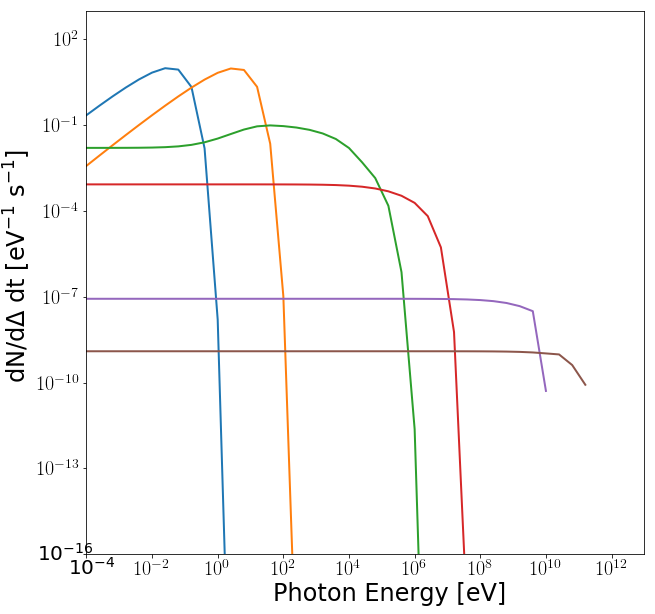

In [5]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)
comp_elec_kineng = np.array([1,1e4, 1e7, 1e8, 1e10, 1e11])

engloss_tf.plot(ax, ind=comp_elec_kineng, indtype='in_eng', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/d$\Delta$ dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-16, 1e3])

In [6]:
sec_elec_tf = copy.deepcopy(engloss_tf)
i = 3
print(sec_elec_tf.in_eng[i])
utils.compare_arr([sec_elec_tf[i].eng, sec_elec_tf[i].dNdE])
print(sec_elec_tf[i].totN())
a = sec_elec_tf[i].toteng()
sec_elec_tf[i].engloss_rebin(sec_elec_tf.in_eng[i])
print(sec_elec_tf[i].totN())
b = sec_elec_tf[i].toteng()
print(sec_elec_tf.in_eng[i])
print(a+b)

15.8489319246
[[ 0.0001  0.06706602]
 [ 0.00025118864  0.14913944]
 [ 0.00063095734  0.32605988]
 [ 0.0015848932  0.69701493]
 [ 0.0039810717  1.444365]
 [ 0.01  2.8587792]
 [ 0.025118864  5.2541453]
 [ 0.063095734  8.4252256]
 [ 0.15848932  10.039058]
 [ 0.39810717  5.5602963]
 [ 1.0  0.35742638]
 [ 2.5118864  8.0510524e-05]
 [ 6.3095734  1.9940655e-14]
 [ 15.848932  2.7916703e-38]
 [ 39.810717  2.627288e-97]
 [ 100.0  0.0]
 [ 251.18864  0.0]
 [ 630.95734  0.0]
 [ 1584.8932  0.0]
 [ 3981.0717  0.0]
 [ 10000.0  0.0]
 [ 25118.864  0.0]
 [ 63095.734  0.0]
 [ 158489.32  0.0]
 [ 398107.17  0.0]
 [ 1000000.0  0.0]
 [ 2511886.4  0.0]
 [ 6309573.4  0.0]
 [ 15848932.0  0.0]
 [ 39810717.0  0.0]
 [ 1e+08  0.0]
 [ 2.5118864e+08  0.0]
 [ 6.3095734e+08  0.0]
 [ 1.5848932e+09  0.0]
 [ 3.9810717e+09  0.0]
 [ 1e+10  0.0]
 [ 2.5118864e+10  0.0]
 [ 6.3095734e+10  0.0]
 [ 1.5848932e+11  0.0]
 [ 3.9810717e+11  0.0]]
4.47767359823
[[ -3.98107171e+11   0.00000000e+00   1.00000000e-04   0.00000000e+00]
 [ -1

In [7]:
a = np.array([1,2,3,4,5])
a[a < 2]

array([1])